<a href="https://colab.research.google.com/github/lovezoyaxu/car-following-model-in-mixtraffic/blob/main/mixtraffic_ppo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

get idea from : https://github.com/boyu-ai/Hands-on-RL

In [ ]:
import gym
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import random

Get data

In [ ]:
# Download data
!wget https://raw.githubusercontent.com/lovezoyaxu/car-following-model-in-mixtraffic/master/L1T100_waymo_train_data.mat --output-document=trainSet.mat
!wget https://raw.githubusercontent.com/lovezoyaxu/car-following-model-in-mixtraffic/master/L1T100_waymo_test_data.mat --output-document=testSet.mat#

# load training data
train = sio.loadmat('trainSet.mat')['calibrationData'][:, 0]
test = sio.loadmat(f'testSet.mat')['validationData'][:, 0]

# variable for the columns are [space, svSpd, relSpd, lvSpd], time interval is 0.1 seconds.
# speed in m/s, space in m.
train.shape, test.shape

--2024-05-16 07:30:30--  https://raw.githubusercontent.com/lovezoyaxu/car-following-model-in-mixtraffic/master/L1T100_waymo_train_data.mat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2111996 (2.0M) [application/octet-stream]
Saving to: ‘trainSet.mat’

trainSet.mat        100%[===================>]   2.01M  --.-KB/s    in 0.07s   

2024-05-16 07:30:30 (29.6 MB/s) - ‘trainSet.mat’ saved [2111996/2111996]

--2024-05-16 07:30:30--  https://raw.githubusercontent.com/lovezoyaxu/car-following-model-in-mixtraffic/master/L1T100_waymo_test_data.mat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... conne

((409,), (403,))

Restrictions regarding car following

In [ ]:
ACC_LIMIT = 3 # the limit of acceleration, this can be calibrated based on the data
Ts = 0.1 # time interval for data sampling

Two functions, one filtering, one taking advantage

In [ ]:
from tqdm import tqdm
import collections


def moving_average(a, window_size):
    cumulative_sum = np.cumsum(np.insert(a, 0, 0))
    middle = (cumulative_sum[window_size:] - cumulative_sum[:-window_size]) / window_size
    r = np.arange(1, window_size-1, 2)
    begin = np.cumsum(a[:window_size-1])[::2] / r
    end = (np.cumsum(a[:-window_size:-1])[::2] / r)[::-1]
    return np.concatenate((begin, middle, end))


def compute_advantage(gamma, lmbda, td_delta):
    td_delta = td_delta.detach().numpy()
    advantage_list = []
    advantage = 0.0
    for delta in td_delta[::-1]:
        advantage = gamma * lmbda * advantage + delta
        advantage_list.append(advantage)
    advantage_list.reverse()
    return torch.tensor(advantage_list, dtype=torch.float)

gym

In [ ]:

from gym.spaces import Box
from copy import deepcopy

class CarFolEnv(gym.Env):
    def __init__(self, split = 'train', his_horizon = 10, collision_penalty = 1000):
        """
        split: train or test dataset to use
        his_horizon: number of time steps for history buffer
        collision_penalty: reward penalty if there is a collision
        """
        self.his_horizon = his_horizon
        self.collision_penalty = collision_penalty
        self.split = split

        # Define obs and action space
        self.observation_space = Box(low = -np.inf, high = np.inf, shape = (3*self.his_horizon,), dtype = np.float32)
        self.action_space = Box(low = -1, high = 1, shape = (1,), dtype = np.float32)

    def reset(self):
        # Randomly select an event from the datset
        if self.split == 'train':
            self.data = random.choice(train)
            #self.data = train[382]
        elif self.split == 'test':
            self.data = random.choice(test)
            #self.data = test[0]

        self.lv_spd = self.data[:, -1]
        self.frame = self.his_horizon

        self.sim_data = deepcopy(self.data[:, :-1])

        # Input data for policy network, considering hisotry buffer
        obs = self.sim_data[self.frame - self.his_horizon:self.frame].flatten()

        return obs

    def step(self, action):
        # TODO: Finish the car step function
        # Given an acceleration, update car-following states

        # Current simulated state
        spacing, sv_spd, rel_spd = self.sim_data[self.frame - 1]

        # Increase frame count
        self.frame += 1

        acceleration = action[0]+0.0001

        # Udpate state based on newton equation
        sv_spd_ = max(0.001, sv_spd+acceleration*Ts)
        rel_spd_ = self.lv_spd[self.frame - 1] - sv_spd_
        spacing_ = spacing + Ts*rel_spd_

        # Update sim_data 更新以后，除了前十个，后面的都是a选择走出来的（a搞出来的轨迹）
        self.sim_data[self.frame -1] = np.asarray([spacing_, sv_spd_, rel_spd_])
        obs = self.sim_data[self.frame - self.his_horizon:self.frame].flatten()

        is_collision = True if spacing_ <= 0 else False
        if is_collision or self.frame == len(self.data):
          done = True
        else:
          done = False


        # Calculating reward information use self speed
        sv_spd_gt = self.data[self.frame - 1,1]
        r = -np.log(np.abs(sv_spd_gt - sv_spd_)/sv_spd) - is_collision*self.collision_penalty
        info = {}



        return obs, r, done, info


Build models (policy network, action network, ppo execution structure), etc

In [ ]:
class PolicyNetContinuous(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNetContinuous, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc_mu = torch.nn.Linear(hidden_dim, action_dim)
        self.fc_std = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        mu = ACC_LIMIT * torch.tanh(self.fc_mu(x))
        std = F.softplus(self.fc_std(x))
        return mu, std

class ValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim):
        super(ValueNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

class PPOContinuous:

    def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr,
                 lmbda, epochs, eps, gamma, device):
        self.actor = PolicyNetContinuous(state_dim, hidden_dim,action_dim).to(device)
        self.critic = ValueNet(state_dim, hidden_dim).to(device)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(),lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(),lr=critic_lr)

        self.gamma = gamma
        self.lmbda = lmbda
        self.epochs = epochs
        self.eps = eps
        self.device = device

    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        mu, sigma = self.actor(state)
        action_dist = torch.distributions.Normal(mu, sigma)
        action = action_dist.sample()
        return [action.item()]

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],dtype=torch.float).to(self.device)

        actions = torch.tensor(transition_dict['actions'],dtype=torch.float).view(-1, 1).to(self.device)

        rewards = torch.tensor(transition_dict['rewards'],dtype=torch.float).view(-1, 1).to(self.device)

        next_states = torch.tensor(transition_dict['next_states'],dtype=torch.float).to(self.device)

        dones = torch.tensor(transition_dict['dones'],dtype=torch.float).view(-1, 1).to(self.device)


        td_target = rewards + self.gamma * self.critic(next_states) * (1 - dones)
        td_delta = td_target - self.critic(states)
        advantage = compute_advantage(self.gamma, self.lmbda, td_delta.cpu()).to(self.device)
        mu, std = self.actor(states)
        action_dists = torch.distributions.Normal(mu.detach(), std.detach())

        old_log_probs = action_dists.log_prob(actions)

        for _ in range(self.epochs):
            mu, std = self.actor(states)
            action_dists = torch.distributions.Normal(mu, std)
            log_probs = action_dists.log_prob(actions)
            ratio = torch.exp(log_probs - old_log_probs)
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1 - self.eps, 1 + self.eps) * advantage
            actor_loss = torch.mean(-torch.min(surr1, surr2))
            critic_loss = torch.mean(
                F.mse_loss(self.critic(states), td_target.detach()))
            self.actor_optimizer.zero_grad()
            self.critic_optimizer.zero_grad()

            actor_loss.requires_grad_()
            critic_loss.requires_grad_()

            actor_loss.backward()
            critic_loss.backward()
            self.actor_optimizer.step()
            self.critic_optimizer.step()

Official references to ppo, Strategy Network, Value Network, and Self-created gym. Training model

In [ ]:
actor_lr = 1e-4
critic_lr = 5e-3
num_episodes = 2000
hidden_dim = 128
gamma = 0.9
lmbda = 0.9
epochs = 10
eps = 0.2
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


env_name = 'CarFolEnv'
env = CarFolEnv()
env.seed(0)
torch.manual_seed(0)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
print(state_dim,action_dim)
agent = PPOContinuous(state_dim, hidden_dim, action_dim, actor_lr, critic_lr, lmbda, epochs, eps, gamma, device)


model_type = 'actor'
his_horizon = 10
save = f'{model_type}_horizon{his_horizon}.pt'

best_reward = -1000000
return_list = []
for i in range(1000):

        for i_episode in range(int(num_episodes / 10)):
            episode_return = 0
            transition_dict = {
                'states': [],
                'actions': [],
                'next_states': [],
                'rewards': [],
                'dones': []
            }
            state = env.reset()
            done = False
            while not done:
                action = agent.take_action(state)
                next_state, reward, done, _ = env.step(action)
                transition_dict['states'].append(state)
                transition_dict['actions'].append(action)
                transition_dict['next_states'].append(next_state)
                transition_dict['rewards'].append(reward)
                transition_dict['dones'].append(done)
                state = next_state
                episode_return += reward
            return_list.append(episode_return)
            agent.update(transition_dict)

            if i > 600:
              if best_reward == -1000000 or best_reward < episode_return:
                best_reward = episode_return

                  # save the best model
                with open(save, 'wb') as f:
                  torch.save(agent, f)

            if done == True:
              break


        if i % 100 == 0:
            print("Epoch: {0}| state value: {1:.7f}".format(i , episode_return))


print(best_reward)

/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


30 1
Epoch: 0| state value: -906.1878007
Epoch: 100| state value: 604.5014321
Epoch: 200| state value: 528.6896789
Epoch: 300| state value: 607.5690402
Epoch: 400| state value: 513.7248693
Epoch: 500| state value: 414.0007121
Epoch: 600| state value: 424.2375294
Epoch: 700| state value: 364.5680878
Epoch: 800| state value: 430.8035767
Epoch: 900| state value: 380.9987217
697.3100119279334


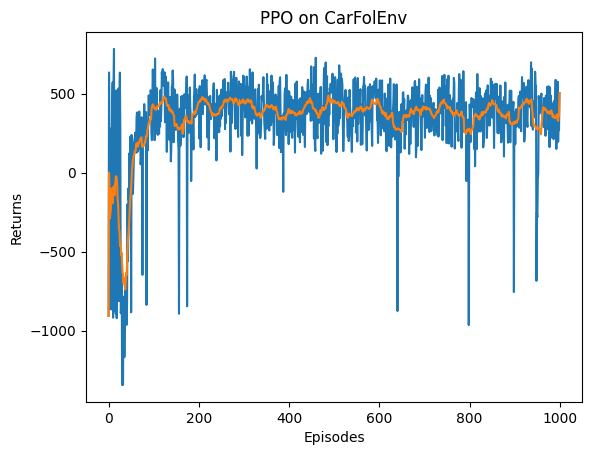

In [ ]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('PPO on {}'.format(env_name))


mv_return = moving_average(return_list, 21)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('PPO on {}'.format(env_name))
plt.show()

In [ ]:
# Load the best model saved
with open(f'{save}', 'rb') as f:
    test_agent = torch.load(f)

env = CarFolEnv(split = 'test')

transition_dict = {
                'states': [],
                'actions': [],
                'next_states': [],
                'rewards': [],
                'dones': []
            }

state = env.reset()
done = False
while not done:
    action = test_agent.take_action(state)
    next_state, reward, done, _ = env.step(action)
    transition_dict['states'].append(state)
    transition_dict['actions'].append(action)
    transition_dict['next_states'].append(next_state)
    transition_dict['rewards'].append(reward)
    transition_dict['dones'].append(done)
    state = next_state
    if done == True: #有done就是一段路径结束了，该下条路径了
        break
actions = transition_dict['actions']
print(actions)


[[-1.6332082748413086], [1.9141535758972168], [0.8984493613243103], [0.2133285403251648], [0.8155922889709473], [0.44352322816848755], [1.781938076019287], [0.1970648467540741], [-1.1246302127838135], [-2.3231606483459473], [0.7016907334327698], [-0.526339590549469], [-1.8304457664489746], [-1.4524049758911133], [0.4886905550956726], [0.8901974558830261], [0.4940446615219116], [0.3871685564517975], [-0.13132701814174652], [-0.3111770749092102], [-0.3109990954399109], [0.5754600763320923], [1.464726209640503], [0.5448251366615295], [0.47551798820495605], [-1.0733081102371216], [-0.7197991013526917], [0.722971498966217], [1.2996420860290527], [0.8781883716583252], [-0.3265479803085327], [-1.0790208578109741], [0.6987686157226562], [1.328545331954956], [1.3220279216766357], [-0.49194496870040894], [-0.6936209797859192], [-0.4723320007324219], [0.27522438764572144], [0.11079931259155273], [1.9760875701904297], [0.28706589341163635], [-0.12562522292137146], [-0.5742396116256714], [0.2186834

0.38774097686123854


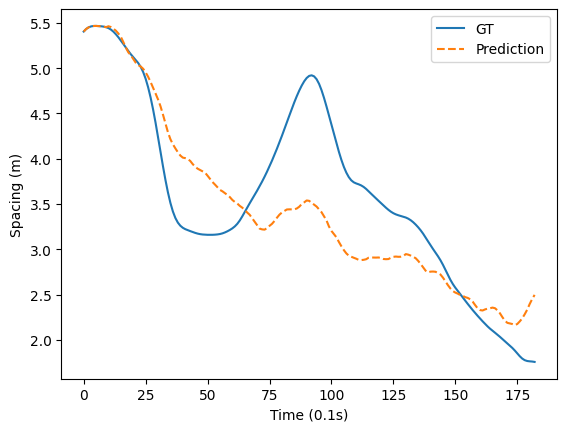

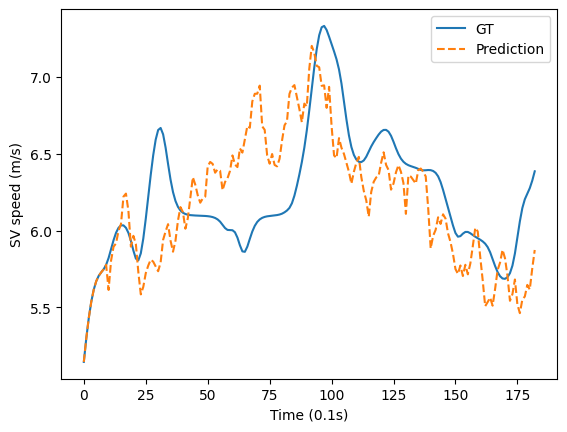

In [ ]:
spacing_obs, spacing_sim = env.data[:, 0], env.sim_data[:, 0]
sv_spd_obs, sv_spd_sim = env.data[:, 1], env.sim_data[:, 1]

# plot for one event
plt.plot(spacing_obs, label = 'GT')
plt.plot(spacing_sim, '--', label = 'Prediction')
plt.legend()
plt.xlabel(f'Time ({Ts}s)');
plt.ylabel('Spacing (m)');

# speed part
plt.figure()
plt.plot(sv_spd_obs, label = 'GT')
plt.plot(sv_spd_sim, '--', label = 'Prediction')
plt.legend()
plt.xlabel(f'Time ({Ts}s)');
plt.ylabel('SV speed (m/s)');

mse_spacing = np.mean((spacing_sim - spacing_obs)**2)
print(mse_spacing)